In [57]:
import pandas as pd
import numpy as np
import os.path as op
import unicodedata
import sys
from gensim.models import FastText
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler


#basename = op.split(op.dirname(op.realpath(__file__)))[0]
basename = "/Users/Adrian/Desktop/WDDS/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
load_library(op.join(basename, 'readWrite'))
from readWrite import readFile
from sys_utils import load_library
#from mongoDB_utils import connect_to_database
from tweet_utils import *

from preprocess import Preprocess
prep = Preprocess()



trainingData = pd.read_csv("ManualLabel_TypeDiabetes_Sexe.csv", usecols=["text", "user_description", "user_name", "user_screen_name", "HasDiabetes", 
                            "Type_Diabetes", "Sexe", "History_HasDiab", "History_TypeDiab", "History_Sex"],
                           #converters={'user_description': lambda x: tt(x)}
                           #converters={'HasDiabetes': lambda x: int(x, 16)}
                          #dtype={'Type_Diabetes':np.int32}
                          )

#trainingData['user_description'].replace("nan", "")
#trainingData['user_description'].replace(np.NaN, "")
print(trainingData.dtypes)
print(trainingData.shape)
#trainingData.text.isnull().values.any()
trainingData.head(5)

text                 object
user_description     object
user_name            object
user_screen_name     object
HasDiabetes         float64
Type_Diabetes         int64
Sexe                 object
History_HasDiab      object
History_TypeDiab    float64
History_Sex          object
dtype: object
(1897, 10)


,text,user_description,user_name,user_screen_name,HasDiabetes,Type_Diabetes,Sexe,History_HasDiab,History_TypeDiab,History_Sex
0,@Dmartelz24 @Dterrazas760 Then diabetes Kankle...,Account Manager for Dr.Pepper Snapple Group. D...,Jimmy Martinez,R8TERFAN1,0.0,0,M,NaN,NaN,NaN
1,"Woke up with a 30 blood sugar, hate half a can...",It's worth it.,Kelsey Smith,Kelsey_Smith88,1.0,1,U,NaN,NaN,M
2,I’m going back to my roots. I’m trying shakes ...,Life isn't about surviving the storms...it's a...,Lennie Ledesma,lennieledesma,1.0,0,U,NaN,NaN,M
3,Praying I don’t get diabetes,I'm still not fat I'm just short for my weight...,Regina George 💎,BlowindatPINK_,0.0,0,F,NaN,NaN,NaN
4,Happy world diabetes today💙💙 #t1dstrong https:...,I have a dead pancreas☹️ santiago🐬,riley:),itsRiMay,1.0,1,F,NaN,NaN,NaN


In [38]:
gender_names = pd.read_csv("gender_names_2017.txt", sep=",")
gender_names.columns = ["name", "gender", "OccurencesName"]

print(gender_names.shape)
gender_names.name = gender_names.name.map(lambda name: name.lower())

print(gender_names[gender_names["name"] == "olivia"])

def choose_most_occuring_name(df):
    if df.shape[0] == 1: return df
    else:
        maxEl = df.OccurencesName.max(axis=0)
        return df[df["OccurencesName"] == maxEl]

print(gender_names.head(5) )
# in duplicate cases (Name exist for male and female) take only the one that occurs more often
gender_names = gender_names.groupby("name",as_index=False).apply(choose_most_occuring_name)
gender_names.reset_index(drop=True, inplace=True)
print(gender_names.shape)

gender_names.head(5)


(32468, 3)
         name gender  OccurencesName
0      olivia      F           18632
26227  olivia      M              10
       name gender  OccurencesName
0    olivia      F           18632
1       ava      F           15902
2  isabella      F           15100
3    sophia      F           14831
4       mia      F           13437
(29964, 3)


,name,gender,OccurencesName
0,aaban,M,11
1,aabriella,F,6
2,aadam,M,18
3,aadan,M,8
4,aadarsh,M,15


In [40]:
tweets = "/Users/Adrian/Desktop/WDDS/Models_Data/tweets_10042019/matching-tweets_diab_noRetweetsDupl_personal_noJokes_LocationUS_geoCityCodeNotNull.parquet"
temp = pd.read_parquet(tweets).sample(n=100)

temp.reset_index(drop=True, inplace=True, level="user_name")

temp.head(1)

,id,created_at,lang,retweet_count,text,user_name,user_screen_name,user_location,user_followers_count,user_friends_count,...,geo_name,geo_code,geo_type,geo_country_code,geo_city_code,geo_adm1_code,geo_adm2_code,_score_,_startIndex_,_endIndex_
121957,1.023650e+18,Sun Jul 29 19:21:03 +0000 2018,en,0,@PolloParaLlevar @BlackRose96 @AbbyMartin @Liz...,Yvonne 🇺🇸,Infidel_Yvonne,"Las Vegas, NV",4402.0,1084.0,...,Las Vegas,5506956,PPLA2,US,5506956,NV,003,349.138428,0,3


In [41]:
tweets = "/Users/Adrian/Desktop/WDDS/Models_Data/tweets_10042019/matching-tweets_diab_noRetweetsDupl_personal_noJokes_LocationUS_geoCityCodeNotNull.parquet"

df = readFile(tweets, columns="id, text, user_description, user_name, user_screen_name") \
        .sample(n=12000, random_state=1) 

df.reset_index(drop=True, inplace=True, level="user_name")

print(df.shape)
print("=")
def get_sex(name):
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        return firstName.lower()
    except:
        return None 

df["firstName"] = df.user_name.map(get_sex)

print(df.shape)
print("gender names:", gender_names.shape)
new = pd.merge(df, gender_names, how='inner', left_on="firstName", right_on="name")
new = new[new.OccurencesName > 500] # take only examples of names that occur often
new = new[["text", "user_description", "user_name", "gender"]]
print(new.shape)


Local mode: Read file..
(12000, 5)
=
(12000, 6)
gender names: (29964, 3)
(3695, 4)


In [15]:
data_kaggle = pd.read_csv("gender_kaggle.csv", sep=",", usecols=["_golden", "gender", "gender:confidence", "description", "name", "text" ], 
                          encoding='latin_1')#'ISO-8859-1')#'utf-8')
print(data_kaggle.shape)
print(data_kaggle["gender"].value_counts())
def recode_gender(sex):
    if sex == "male" : return "M"
    elif sex == "female" : return "F"
    elif sex == "unknown" : return 'U'
    else: print("Weird sex: ", sex)

data_kaggle = data_kaggle[data_kaggle["gender:confidence"] == 1.0]
data_kaggle = data_kaggle[(data_kaggle["gender"] == "male") | (data_kaggle["gender"] == "female") | (data_kaggle["gender"] == "unknown") ]
print(data_kaggle["gender"].value_counts())

data_kaggle.gender = data_kaggle.gender.map(recode_gender)
data_kaggle["user_description"] = data_kaggle.description
data_kaggle["user_name"] = data_kaggle.name # in the orignial kaggle file, it is the screenname, but here we save it in user_name column to be able to merge with normal file
data_kaggle["history_sex_total"] = data_kaggle.gender
data_kaggle = data_kaggle[["text", "user_description", "user_name", "history_sex_total"]]
#data_kaggle.text.values[0:20]
data_kaggle.head(5)




(20050, 6)
female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64
female     5367
male       4653
unknown     122
Name: gender, dtype: int64


,text,user_description,user_name,history_sex_total
0,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.,sheezy0,M
1,ÛÏIt felt like they were my friends and I was...,I'm the author of novels filled with family dr...,DavdBurnett,M
3,Hi @JordanSpieth - Looking at the url - do you...,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",douggarland,M
4,Watching Neighbours on Sky+ catching up with t...,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,WilfordGemma,F
5,"Ive seen people on the train with lamps, chair...",you don't know me.,monroevicious,F


In [42]:
model_we = FastText.load("/Users/Adrian/Desktop/WDDS/Models_Data/FastText_model/ft_wordembeddings_09112018.model")
#model_we = FastText.load("/Users/Adrian/Desktop/WDDS/Models_Data/FastText_model/ft_wordembeddings_dim300_minCount3_iter50_26032019")



In [43]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)

    return tweet

def labelEncode(sex):
    #print(sex)
    if sex == "M": return(0) 
    elif sex == "F": return(1)
    elif sex == "U": return(2)
    else: return(2)


def create_history_sex_column(row):
    #print(row)
    if row["History_Sex"] == "M": return "M"
    elif row["History_Sex"] == "F": return "F"
    elif row["History_Sex"] == "U": return "U"
    elif pd.isnull(row["History_Sex"]): return row["Sexe"]
    else: print("ERROR: Should not occur:  ", row["Sexe"], ";;;", row["History_Sex"])

trainingData['history_sex_total'] = trainingData.apply (lambda row: create_history_sex_column(row), axis=1)

sex = trainingData.Sexe
history_sex = trainingData.history_sex_total


In [44]:
# APPEND OWN TWEETS THAT ARE MATCHED WITH GENDER LIST
print("trainingData.shape:", trainingData.shape)
print("own data.shape:", new.shape)

label = "history_sex_total"
data_pd = trainingData[["text", "user_description", "user_name", label]]
new[label] = new["gender"]
del new["gender"]

data_pd = data_pd.append(new, ignore_index=True).sample(frac=1.0) # append dataframes and sample
print("merged.shape:", data_pd.shape)
print(data_pd[label].value_counts())
data_pd.head()

trainingData.shape: (1897, 11)
own data.shape: (3695, 4)
merged.shape: (5592, 4)
F    2802
M    2415
U     374
Name: history_sex_total, dtype: int64


,text,user_description,user_name,history_sex_total
839,@MrLuisMGuerrero @TheReturnOfBad Got it. My m...,"Husband, father, son, friend, sports nut, Char...",JZags,M
805,@avafay ps. did you see i almost have diabete...,"liberal new yorker. lover of theatre, film, my...",melissa,F
4569,Andre CANNOT PLAY WITH THOSE DIABETES!!!! HE C...,I am a young rebellious woman who is confident...,Tiffany Harris,F
998,@wbuxtonofficial You’re going to get diabetes ...,Anti-feminist. MRA. Moderate MGTOW. Independen...,Philosopher King,M
891,“I can’t go into haunted houses I’ll catch dia...,"I love to thrift, rip Mac 🙇🏽",Pleasures,M


In [45]:
# APPEND KAGGLE DATA 
"""
print("trainingData.shape:", trainingData.shape)
print("data_kaggle.shape:", data_kaggle.shape)
#label = "sex"
label = "history_sex_total"
data_pd = trainingData[["text", "user_description", "user_name", label]]
#data_pd.head()

#data_pd = data_kaggle
#data_pd = data_pd.append(data_kaggle, ignore_index=True).sample(frac=1.0) # append dataframes and sample
print("data_pd.shape:", data_pd.shape)
print(data_pd[label].value_counts())
data_pd.head(5)
"""

'\nprint("trainingData.shape:", trainingData.shape)\nprint("data_kaggle.shape:", data_kaggle.shape)\n#label = "sex"\nlabel = "history_sex_total"\ndata_pd = trainingData[["text", "user_description", "user_name", label]]\n#data_pd.head()\n\n#data_pd = data_kaggle\n#data_pd = data_pd.append(data_kaggle, ignore_index=True).sample(frac=1.0) # append dataframes and sample\nprint("data_pd.shape:", data_pd.shape)\nprint(data_pd[label].value_counts())\ndata_pd.head(5)\n'

In [46]:

data_pd.text = data_pd.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_pd["temp_userDesc"] = data_pd.user_description.map(lambda userDesc: 0 
                                                if isinstance(userDesc, float) or userDesc == " " or userDesc == None
                                                else 1)

data_pd.user_description = data_pd.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) 
                                                if isinstance(userDesc, float) or userDesc == " " or userDesc == None
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))

def userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
        #print("\t FirstName:", firstName)
    except:
        vec = np.zeros((model_we.vector_size, ))
        #print("\t no first name")

    return vec

def TEMP_userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
        return 1
    except:
        #vec = np.zeros((model_we.vector_size, ))
        return 0


#data_pd["temp"] = data_pd.user_name#.map(lambda name: name.split(" ")[0].replace(" ", ""))
data_pd['temp_user_name'] = data_pd.user_name.map(lambda name: TEMP_userName_to_vec(name))
data_pd.user_name = data_pd.user_name.map(lambda name: userName_to_vec(name))
data_pd[label] = data_pd[label].map(labelEncode)


# remove the tweets that are empty because there is no word embedding
data_pd = data_pd[data_pd["text"].apply(lambda x: len(x)>0) ]
print(data_pd.shape)

#data_pd.user_name = data_pd.user_name.map(lambda tweet: prep.remove_non_ascii(tweet))
data_pd.head(3)

"""
# same for data_kaggle
data_kaggle.text = data_kaggle.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_kaggle.user_description = data_kaggle.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) 
                                                if isinstance(userDesc, float) or userDesc == " " 
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))
data_kaggle.user_name = data_kaggle.user_name.map(lambda name: userName_to_vec(name))
data_kaggle[label] = data_kaggle[label].map(labelEncode)
data_kaggle = data_kaggle[data_kaggle["text"].apply(lambda x: len(x)>0) ]
print(data_kaggle.shape)
"""

no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(5592, 6)


/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


'\n# same for data_kaggle\ndata_kaggle.text = data_kaggle.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))\ndata_kaggle.user_description = data_kaggle.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) \n                                                if isinstance(userDesc, float) or userDesc == " " \n                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))\ndata_kaggle.user_name = data_kaggle.user_name.map(lambda name: userName_to_vec(name))\ndata_kaggle[label] = data_kaggle[label].map(labelEncode)\ndata_kaggle = data_kaggle[data_kaggle["text"].apply(lambda x: len(x)>0) ]\nprint(data_kaggle.shape)\n'

In [47]:
# Replace missing values by mean of vectors and not by Array of 0

"""
#print(data_pd.shape)
user_desc_nonZero = data_pd[data_pd.temp_userDesc == 1] # only rows with non zero user_description vectors
mean_user_desc = user_desc_nonZero.user_description.mean()
#print(user_desc_nonZero.shape)
print(type(mean_user_desc), mean_user_desc.shape)

user_name_nonZero = data_pd[data_pd.temp_user_name == 1] # only rows with non zero user_description vectors
mean_user_name = user_name_nonZero.user_name.mean()
#print(user_name_nonZero.shape)
print(type(mean_user_name), mean_user_name.shape)

#data_pd.user_description.loc[data_pd.temp_userDesc == 0] = 1#mean_user_desc
#data_pd.user_name.loc[data_pd.temp_user_name == 0] = 1#mean_user_name

#df['c1'].loc[df['c1'] == 'Value'] = 10
#print(data_pd.shape)
#data_pd.head(100)

def set_mean_userName(row):
    if row["temp_user_name"] == 1: return row["user_name"]
    else: return mean_user_name

def set_mean_userDesc(row):
    if row["temp_userDesc"] == 1: return row["user_description"]
    else: return mean_user_desc

data_pd['user_name'] = data_pd.apply (lambda row: set_mean_userName(row), axis=1)
data_pd['user_description'] = data_pd.apply (lambda row: set_mean_userDesc(row), axis=1)

data_pd.head(100)
"""

'\n#print(data_pd.shape)\nuser_desc_nonZero = data_pd[data_pd.temp_userDesc == 1] # only rows with non zero user_description vectors\nmean_user_desc = user_desc_nonZero.user_description.mean()\n#print(user_desc_nonZero.shape)\nprint(type(mean_user_desc), mean_user_desc.shape)\n\nuser_name_nonZero = data_pd[data_pd.temp_user_name == 1] # only rows with non zero user_description vectors\nmean_user_name = user_name_nonZero.user_name.mean()\n#print(user_name_nonZero.shape)\nprint(type(mean_user_name), mean_user_name.shape)\n\n#data_pd.user_description.loc[data_pd.temp_userDesc == 0] = 1#mean_user_desc\n#data_pd.user_name.loc[data_pd.temp_user_name == 0] = 1#mean_user_name\n\n#df[\'c1\'].loc[df[\'c1\'] == \'Value\'] = 10\n#print(data_pd.shape)\n#data_pd.head(100)\n\ndef set_mean_userName(row):\n    if row["temp_user_name"] == 1: return row["user_name"]\n    else: return mean_user_name\n\ndef set_mean_userDesc(row):\n    if row["temp_userDesc"] == 1: return row["user_description"]\n    else:

In [48]:

class ItemSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        #print("data: ", data.shape, type(data))
        #print("data[key]: ", data[self.key].shape, type(data[self.key]))
        #print("data[key].values: ", data[self.key].values.shape, type(data[self.key].values))
        #print("data[key].values.tolist: ", len(data[self.key].values.tolist()), type(data[self.key].values.tolist()))
        #print("asarray(data[key].values.tolist): ", np.asarray(data[self.key].values.tolist()).shape, type(np.asarray(data[self.key].values.tolist())))
        #print("data[key].head(): ", data[self.key].head())
        return np.asarray(data[self.key].values.tolist())
    
class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, message=""):
        self.message = message
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        print(self.message)
        print("type:", type(X), "len:", X.shape)
        #print(X.head(2))
        return X


In [55]:
# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)

    
from imblearn.pipeline import Pipeline    
    
pipeline  = Pipeline([
                #("debuge", Debug("start")),
                #('concatenateTweetAndUserDesc', CombineTweetAndUserDesc(user_desc=user_desc_vec)),
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([
                                    ('tweetsSelector', ItemSelect(key='text')),
                                    #("debugeq", Debug("text Selector")),
                                ])),
                                ('userDesc', Pipeline([
                                    ('userDescSelector', ItemSelect(key='user_description'))
                                ])),
                                ('userName', Pipeline([
                                    ('userNameSelector', ItemSelect(key='user_name'))
                                ]))  
                            ],
                )),
                #("debuggg", Debug("before model")),
                ('smote', SMOTE(random_state=12, sampling_strategy="auto",  n_jobs=-1)), #, ratio = 1.0 
                ('model', model),
                #("debuggg", Debug("after model")),

            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
                'union__transformer_weights' : #[{"tweet": 1, "userDesc":1, "userName":1},
#                                                {"tweet": 1, "userDesc":1, "userName":0.8}, 
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.6},
#                                                {"tweet": 1, "userDesc":0.7, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.9, "userName":0.5},
#                                                ],
                                               [
#                                                {"tweet": 1, "userDesc":1, "userName":1}, 
#                                                {"tweet": 0.5, "userDesc":1, "userName":1}, 
#                                                {"tweet": 1, "userDesc":1, "userName":0.7},
                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.4}, 
#                                                {"tweet": 1, "userDesc":0.8, "userName":1},
#                                                {"tweet": 0.5, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0, "userName":1},
#                                                {"tweet": 0, "userDesc":0, "userName":1}
                                                ],

                'smote__k_neighbors' : [5],

#               # param for SVC
               'model__kernel' : ["linear"],#["linear", "poly", "rbf"],
               'model__C' : [0.5, 0.1, 0.01],
               'model__tol' : [1e-2, 1e-3],
#               'model__class_weight' : ["balanced", {1:0.5}, {1:1}, {1:1.5}],
#
#               # param for RandomForestClassifier
#               'model__n_estimators' : [50, 100, 150],
#               'model__criterion' : ['gini', 'entropy'],
#               'model__max_features' : ['auto', 'log2'],
#               'model__max_depth' : [ 5, 10, 20, 30]
#
#               # param for XGBoost Best: 0.910828 using {'model__learning_rate': 0.05, 'model__reg_alpha': 0, 'model__max_depth': 3, 'model__reg_lambda': 1.5, 'model__n_estimators': 300}
#               'model__max_depth' : [3],#[3,4],
#              'model__learning_rate' : [0.001, 0.01, 0.1],
#               'model__booster' : ["gbtree", "gblinear", "dart"], # ["gblinear"], #
#               'model__gamma' : [0, 0.01],
#               'model__n_estimators' : [100, 150],
#               'model__reg_alpha' : [0, 0.1],
#               'model__reg_lambda' : [0.5, 1.0]


}


In [56]:

def label_encode(sex):
    #print(sex)
    # M = 0, F = 1, U = 2
    if sex == 0: return(-1) 
    else: return(1)


#print(labels.unique())
print("data:", data_pd.shape, type(data_pd))
X = data_pd[["text", "user_description", "user_name"]]
#y = data_pd[label].map(label_encode)
y = data_pd[label]
#print("X :", X.shape, type(X))
#print("y.unique: ", y.unique())

#temp = data_pd.loc[data_pd[label] != 2]
#print("Temp:", temp.shape, type(temp))
#X = temp[["text", "user_description", "user_name"]]
#y = temp[label]#.map(label_encode)
print("X :", X.shape, type(X))
print("y.unique: ", y.unique())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
print("X_train:", X_train.shape, type(X_train))
print("X_test:", X_test.shape, type(X_test))
print("y_train:", y_train.shape, type(y_train))
print("y_test:", y_test.shape, type(y_test))

## KAGGLE CASE
#temp = X_train
#temp[label] = y_train
#print("temp:", temp.shape, type(temp))
#data_kaggle[label] = data_kaggle[label].map(labelEncode)
#temp = temp.append(data_kaggle, ignore_index=True).sample(frac=1.0) # append dataframes and sample
#print("temp:", temp.shape, type(temp))
#X_train = temp[["text", "user_description", "user_name"]]
#y_train = temp[label]
#print("X_train:", X_train.shape, type(X_train))
#print("y_train:", y_train.shape, type(y_train))



#    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
#    y_train, y_test = y[train_idx], y[test_idx]
    
#    print("X_train:", X_train.shape, type(X_train))

    # Over sample traininig set
    #sm = SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#    ros = RandomOverSampler(random_state=0)
#    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
#    print("X_train_res:", X_train_res.shape, type(X_train_res))

#    X_train_pd = pd.DataFrame(X_train_res, columns=["text", "user_description", "user_name"])
#    X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description", "user_name"])
X_train_pd = pd.DataFrame(X_train, columns=["text", "user_description", "user_name"])
X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description", "user_name"])

print(y_train.unique())
print("Start Grid search...")
grid = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1, verbose=2)#, scoring="roc_auc")
grid.fit(X_train_pd, y_train)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

    #grid.best_estimator_#.fit(X_train_res, y_train_res)
y_pred = grid.best_estimator_.predict(X_test_pd)
#print("F1-Score:", f1_score(y_test, y_pred))
#print("Precision: ",precision_score(y_test, y_pred))
#print("Recall: ", recall_score(y_test, y_pred))    
print("Accuracy: ", accuracy_score(y_test, y_pred))   
print("Performance overall: ")
print(classification_report(y_test, y_pred))


    


data: (5592, 6) <class 'pandas.core.frame.DataFrame'>
X : (5592, 3) <class 'pandas.core.frame.DataFrame'>
y.unique:  [0 1 2]
X_train: (3914, 3) <class 'pandas.core.frame.DataFrame'>
X_test: (1678, 3) <class 'pandas.core.frame.DataFrame'>
y_train: (3914,) <class 'pandas.core.series.Series'>
y_test: (1678,) <class 'pandas.core.series.Series'>
[1 0 2]
Start Grid search...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.6min finished



Best: 0.844660 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
Accuracy:  0.8528009535160905
Performance overall: 
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       744
           1       0.93      0.86      0.89       819
           2       0.36      0.65      0.47       115

   micro avg       0.85      0.85      0.85      1678
   macro avg       0.74      0.80      0.75      1678
weighted avg       0.88      0.85      0.86      1678



In [218]:

# SVC - class
#
# only sex (without history) - SVC 
# Best: 0.441223 using {'model__C': 1.0, 'model__kernel': 'linear', 'model__tol': 0.01}
#
# sex with history - SVC
# Best: 0.496574 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01}
#
# only sex with user description - SCV 
# Best: 0.487612 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.001}
#
# sex with history with user description - SVC -  missing values in userdesc are filled with ones
# Best: 0.541908 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01}

# history_sex, user_description, user_name - SVC -  missing values filled with zeros
# Best: 0.682657 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}

# history_sex, user_description, user_name - SVC - missing values filled with mean
#  Best: 0.676331 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}

# history_sex, user_description, user_name - SVC -  missing values filled with zeros
#Best: 0.668425 using {'model__C': 0.1, 'model__class_weight': {1: 1}, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 1}}
#Accuracy:  0.6631578947368421
#Performance overall: 
#              precision    recall  f1-score   support

#    (M)    0       0.70      0.66      0.68       205
#    (F)    1       0.75      0.79      0.77       252
#    (U)    2       0.39      0.38      0.38       113

#   micro avg       0.66      0.66      0.66       570
#   macro avg       0.61      0.61      0.61       570
#weighted avg       0.66      0.66      0.66       570

# history_sex, user_description, user_name - SVC -  missing values filled with zeros - with kaggle data
#Best: 0.692536 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.7034883720930233
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.70      0.68      0.69      1640
#           1       0.71      0.77      0.74      1834
#           2       0.50      0.03      0.05       138

#   micro avg       0.70      0.70      0.70      3612
#   macro avg       0.64      0.49      0.49      3612
#weighted avg       0.70      0.70      0.69      3612


# SVC only M and F
#Best: 0.805634 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8052516411378556
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.77      0.76      0.76       188
#           1       0.83      0.84      0.84       269

#   micro avg       0.81      0.81      0.81       457
#   macro avg       0.80      0.80      0.80       457
#weighted avg       0.80      0.81      0.81       457

# SVC only M and F - with kaggle data
#Best: 0.720386 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.7167196072769275
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.69      0.69      0.69      1577
#           1       0.74      0.74      0.74      1886

#   micro avg       0.72      0.72      0.72      3463
#   macro avg       0.71      0.71      0.71      3463
#weighted avg       0.72      0.72      0.72      3463

# SVC only kaggle data
#Best: 0.692900 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.7045908183632734
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.68      0.66      0.67      1374
#           1       0.72      0.75      0.73      1632

#   micro avg       0.70      0.70      0.70      3006
#   macro avg       0.70      0.70      0.70      3006
# weighted avg       0.70      0.70      0.70      3006


# SVC kaggle data only in training data 
# Best: 0.696661 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
# Accuracy:  0.6333333333333333
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.58      0.79      0.67       197
#           1       0.68      0.78      0.73       255
#           2       0.60      0.05      0.09       118

#   micro avg       0.63      0.63      0.63       570
#   macro avg       0.62      0.54      0.50       570
#weighted avg       0.63      0.63      0.58       570


# XGBoost with kaggle data 
#Best: 0.675092 using {'model__booster': 'gbtree', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.7}}
#Accuracy:  0.6755260243632336
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.69      0.62      0.65      1640
#           1       0.67      0.78      0.72      1834
#           2       0.43      0.04      0.08       138

#   micro avg       0.68      0.68      0.68      3612
#   macro avg       0.59      0.48      0.48      3612
#weighted avg       0.67      0.68      0.66      3612


# SVC with additional gender data - SMOTE - Taking 5000 random tweets and checking for names
#Best: 0.781409 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.7}}
#Accuracy:  0.7643564356435644
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.84      0.80      0.82       416
#           1       0.88      0.77      0.82       498
#           2       0.33      0.61      0.43        96

#   micro avg       0.76      0.76      0.76      1010
#   macro avg       0.68      0.73      0.69      1010
#weighted avg       0.81      0.76      0.78      1010

# SVC with additional gender data - SMOTE - Taking 8000 random tweets and checking for names
#Best: 0.801309 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8259541984732824
#Performance overall: 
#              precision    recall  f1-score   support
#
#           0       0.87      0.85      0.86       527
#           1       0.93      0.82      0.88       662
#           2       0.42      0.72      0.53       121

#   micro avg       0.83      0.83      0.83      1310
#   macro avg       0.74      0.80      0.75      1310
#weighted avg       0.86      0.83      0.84      1310

# SVC with additional gender data - SMOTE - Taking 9000 random tweets and checking for names
#Best: 0.821901 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
#Accuracy:  0.8213773314203731
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.82      0.86       614
#           1       0.90      0.84      0.87       667
#           2       0.37      0.70      0.49       113

#   micro avg       0.82      0.82      0.82      1394
#   macro avg       0.73      0.79      0.74      1394
#weighted avg       0.86      0.82      0.83      1394



# SVC with additional gender data - SMOTE - Taking 10000 random tweets and checking for names
#Best: 0.826339 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8279352226720648
#Performance overall: 
#              precision    recall  f1-score   support
#
#           0       0.91      0.82      0.86       631
#           1       0.90      0.86      0.88       738
#           2       0.36      0.68      0.48       113

#   micro avg       0.83      0.83      0.83      1482
#   macro avg       0.73      0.79      0.74      1482
#weighted avg       0.86      0.83      0.84      1482

# SVC with additional gender data - SMOTE - Taking 10000 random tweets and checking for names 
#Best: 0.830062 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8312841530054644
#Performance overall: 
#              precision    recall  f1-score   support
#
#           0       0.90      0.83      0.86       638 (m)
#           1       0.90      0.86      0.88       698 (f)
#           2       0.43      0.72      0.54       128 (u)

#   micro avg       0.83      0.83      0.83      1464
#   macro avg       0.74      0.80      0.76      1464
#weighted avg       0.86      0.83      0.84      1464

# SVC with additional gender data - SMOTE - Taking 11000 random tweets and checking for names 
#Best: 0.830398 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8400758533501896
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.90      0.85      0.88       680
#           1       0.93      0.85      0.89       779
#           2       0.38      0.71      0.50       123

#   micro avg       0.84      0.84      0.84      1582
#   macro avg       0.74      0.80      0.75      1582
#weighted avg       0.88      0.84      0.85      1582


# ==============
# TAKE THIS ONE:
# ==============

# SVC with additional gender data - SMOTE - Taking 12000 random tweets and checking for names (can not reproduce)
#Best: 0.844660 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8528009535160905
#Performance overall: 
#              precision    recall  f1-score   support

#   (M)     0       0.92      0.88      0.90       744
#   (F)     1       0.93      0.86      0.89       819
#   (U)     2       0.36      0.65      0.47       115

#   micro avg       0.85      0.85      0.85      1678
#   macro avg       0.74      0.80      0.75      1678
#weighted avg       0.88      0.85      0.86      1678



# SVC with additional gender data - SMOTE - Taking 13000 random tweets and checking for names
#Best: 0.845837 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
#Accuracy:  0.8363431151241535
#Performance overall: 
#              precision    recall  f1-score   support
#
#           0       0.87      0.87      0.87       768
#           1       0.91      0.85      0.88       893
#           2       0.31      0.47      0.37       111

#   micro avg       0.84      0.84      0.84      1772
#   macro avg       0.70      0.73      0.71      1772
#weighted avg       0.86      0.84      0.84      1772

# SVC with additional gender data - SMOTE - Taking 15000 random tweets and checking for names
#Best: 0.857111 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 4, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8514435695538057
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.89      0.87      0.88       818
#           1       0.91      0.88      0.90       969
#           2       0.35      0.52      0.42       118

#   micro avg       0.85      0.85      0.85      1905
#   macro avg       0.72      0.75      0.73      1905
#weighted avg       0.87      0.85      0.86      1905


# SVC with additional gender data - SMOTE - Taking 20000 random tweets and checking for names
#Best: 0.876824 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 4, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.7}}
#Accuracy:  0.8808139534883721
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.92      0.89      0.91      1079
#           1       0.92      0.91      0.91      1212
#           2       0.35      0.50      0.41       117

#   micro avg       0.88      0.88      0.88      2408
#   macro avg       0.73      0.77      0.74      2408
#weighted avg       0.89      0.88      0.89      2408


# SVC with additional gender data - Taking 10000 random tweets and checking for names
#Best: 0.845590 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.825136612021858
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.84      0.87      0.85       638
#           1       0.83      0.90      0.86       698
#           2       0.50      0.23      0.31       128

#   micro avg       0.83      0.83      0.83      1464
#   macro avg       0.73      0.66      0.68      1464
#weighted avg       0.81      0.83      0.81      1464

#####
#####
#####

# SVC - M vs. (F,U)
#Best: 0.798102 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.1, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
#F1-Score: 0.8560700876095119
#Precision:  0.7862068965517242
#Recall:  0.9395604395604396
#Accuracy:  0.7982456140350878

# SVC - F vs. (M,U)
# Best: 0.778598 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.4}}
# F1-Score: 0.8225108225108226
# Precision:  0.76
# Recall:  0.8962264150943396
# Accuracy:  0.7842105263157895

# SVC - U vs. (M,F)
#Best: 0.810852 using {'model__C': 0.5, 'model__class_weight': {1: 1.5}, 'model__kernel': 'linear', 'model__tol': 0.01, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.8, 'userName': 0.4}}
#F1-Score: 0.8822314049586778
#Precision:  0.8356164383561644
#Recall:  0.9343544857768052
#Accuracy:  0.8
#Performance overall: 
#              precision    recall  f1-score   support

#    (U)   -1       0.49      0.26      0.34       113
#   (M,F)   1       0.84      0.93      0.88       457

#   micro avg       0.80      0.80      0.80       570
#   macro avg       0.66      0.60      0.61       570
#weighted avg       0.77      0.80      0.77       570


# SVC - ignore U -> M vs F
# Best: 0.810775 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.1, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.9, 'userName': 0.4}}
# F1-Score: 0.8875855327468231
# Precision:  0.8021201413427562
# Recall:  0.9934354485776805
# Accuracy:  0.7982456140350878


# XGBOOST - U vs. (M,F)
# Best: 0.802319 using {'model__booster': 'gblinear', 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 0.5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
# F1-Score: 0.8899707887049659
# Precision:  0.8017543859649123
# Recall:  1.0
# Accuracy:  0.8017543859649123

# XGBOOST - F vs. (M, U)
# Best: 0.565630 using {'model__booster': 'gblinear', 'model__learning_rate': 0.02, 'model__max_depth': 3, 'model__n_estimators': 200, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 1}}
# F1-Score: 0.7170236753100337
# Precision:  0.5588752196836555
# Recall:  1.0
# Accuracy:  0.5596491228070175


In [52]:

# SVC with additional gender data - SMOTE - Taking 12000 random tweets and checking for names (can not reproduce)
#Best: 0.844660 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 0.001, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 1, 'userName': 0.5}}
#Accuracy:  0.8528009535160905
#Performance overall: 
#              precision    recall  f1-score   support

#   (M)     0       0.92      0.88      0.90       744
#   (F)     1       0.93      0.86      0.89       819
#   (U)     2       0.36      0.65      0.47       115

#   micro avg       0.85      0.85      0.85      1678
#   macro avg       0.74      0.80      0.75      1678
#weighted avg       0.88      0.85      0.86      1678

from sklearn.externals import joblib
joblib.dump(grid.best_estimator_, 'gender_classifier.pkl', compress = 1)

['gender_classifier.pkl']

Classes before: ['M' 'F' 'U']
unique labels: [0 1 2]
Classes: ['M' 'F' 'U']
Confusion matrix, without normalization
[[651  39  54]
 [ 37 705  77]
 [ 22  18  75]]
Classes before: ['M' 'F' 'U']
unique labels: [0 1 2]
Classes: ['M' 'F' 'U']
Normalized confusion matrix
[[0.88 0.05 0.07]
 [0.05 0.86 0.09]
 [0.19 0.16 0.65]]


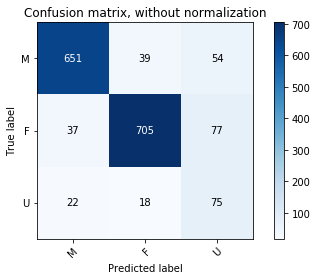

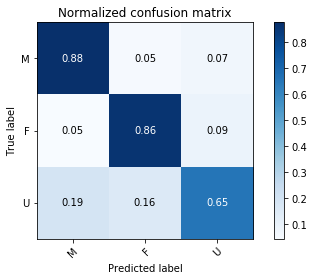

In [51]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print("Classes before:", classes)
    print("unique labels:", unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    print("Classes:", classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

class_names = np.array(["M", "F", "U"])
#class_names = np.array(["M", "F"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()